# Corner detection

In [1]:
import numpy as np
import math
import skimage
from skimage import io
from skimage import filters
from skimage import util
import matplotlib as mpl
import matplotlib.pyplot as plt
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
#print("pandas version: %s"%pd.__version__)
print("skimage version: %s"%skimage.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
skimage version: 0.17.2
matplotlib version: 3.3.1


In [3]:
from ipynb.fs.full.edges_contours import dip_horizontalDerivative
from ipynb.fs.full.edges_contours import dip_verticalDerivative

(200, 200)

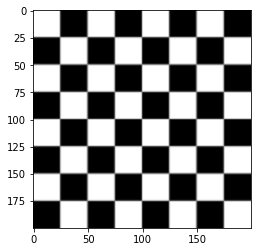

In [4]:
checkboard_img = skimage.data.checkerboard()
plt.imshow(checkboard_img, cmap='gray')
checkboard_img.shape

In [8]:
def dip_gaussianFilter(image):
    # Creates a smoothed image from the input one by computing the
    # average value of each pixel from its neighbors' values. The size
    # of the filter is 5x5
    H = np.array(((0, 1, 2, 1, 0), 
                  (1, 3, 5, 3, 1), 
                  (2, 5, 9, 5, 2), 
                  (1, 3, 5, 3, 1), 
                  (0, 1, 2, 1, 0))) # filter
    rows = image.shape[0]
    cols = image.shape[1]
    smooth_img = np.zeros((rows, cols), dtype=int)
    
    for col in range(0, cols - 1):
        for row in range(0, rows - 1):
            sum = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    v = image[row + i, col + j] * H[i + 1, j + 1]
                    sum = sum + v
            smooth_img[row, col] = int(round( sum ))
    
    return smooth_img / 57

In [12]:
def corner_response(image, alpha, threshold):
    rows = image.shape[0]
    cols = image.shape[1]
    candidates = np.zeros((100, 2), dtype=int)
    Ix = dip_horizontalDerivative(image)
    Iy = dip_verticalDerivative(image)
    A = Ix * Ix
    B = Iy * Iy
    C = Ix * Iy
    A_ = dip_gaussianFilter(A)
    B_ = dip_gaussianFilter(B)
    C_ = dip_gaussianFilter(C)
    Q = A_ * B_  - C_ * C_ - alpha * (A_ + B_) * (A_ + B_)
    
    counter = 0
    for col in range(0, cols - 1):
        for row in range(0, rows - 1):
            if Q[row, col] > threshold and row > 0 and col > 0:
                candidates[counter, 0] = row
                candidates[counter, 1] = col
                counter = counter + 1
    
    corners = np.zeros((counter, 2), dtype=int)
    for i in range(0, counter):
        corners[i, 0] = candidates[i, 0]
        corners[i, 1] = candidates[i, 1]
    
    return corners

In [13]:
corners = corner_response(checkboard_img, 0.17, 1000000)
corners.shape

(49, 2)

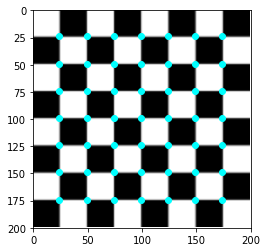

In [14]:
fig, ax = plt.subplots()
ax.imshow(checkboard_img, cmap=plt.cm.gray)
ax.plot(corners[:, 1], corners[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax.axis((0, 200, 200, 0))
plt.show()

## Skimage test

In [16]:
from skimage.feature import corner_harris, corner_peaks, corner_subpix
coords = corner_peaks(corner_harris(checkboard_img), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(checkboard_img, coords, window_size=13)
coords.shape

(49, 2)

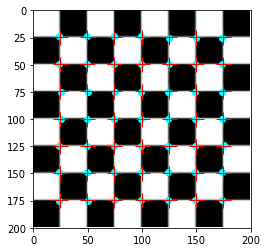

In [17]:
fig, ax = plt.subplots()
ax.imshow(checkboard_img, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 200, 200, 0))
plt.show()